Author: Python Engineer: Machine Learning algorithm implementations from scratch. https://www.youtube.com/playlist?list=PLqnslRFeH2Upcrywf-u2etjdxxkL8nl7E

In [1]:
# %load decision_tree
from collections import Counter
import numpy as np

def entropy(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])

In [2]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None # self.value != None

In [3]:
class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))
        # stopping criteria
        if (
            depth >= self.max_depth
            or n_labels == 1
            or n_samples < self.min_samples_split
        ):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)
        print('n_features, self.n_feats',n_features, self.n_feats,)
        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # greedily select the best split according to information gain
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)

        # grow the children that result from the split
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        # parent loss
        parent_entropy = entropy(y)

        # generate split
        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # compute the weighted avg. of the loss for the children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        # information gain is difference in loss before vs. after split
        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

In [4]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

data = datasets.load_breast_cancer()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

print(y_train) # 注意:y_train若有負值，計算entropy會出錯

clf = DecisionTree(max_depth=3)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = accuracy(y_test, y_pred)

print("Accuracy:", acc)


[1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 0 1 0 1 0 0 1
 1 0 1 1 0 1 0 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 1 0 1 1
 1 1 0 1 1 0 0 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 1
 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 1 0 1
 1 0 0 1 1 1 0 1 1 1 1 0 1 1 0 0 0 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 0 1 1
 0 1 0 0 0 1 1 1 0 0 1 0 0 1 1 0 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1
 1 0 1 0 1 0 1 1 0 1 0 0 1 0 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0
 1 0 1 1 1 1 0 0 1 1 1 1 0 0 0 1 1 0 0 1 0 1 1 1 0 0 1 1 1 0 1 0 0 1 1 1 1
 0 1 0 0 0 1 0 0 0 1 1 1 1 0 1 0 0 0 1 0 1 1 0 0 1 0 0 1 0 1 0 1 0 1 1 0 1
 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 0 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 1 1 1 0 1
 1 1 0 1 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 1 0 0 0
 1 0 1 0 0 1 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 0 1 0 1 0 1]
n_features, self.n_feats 30 30
n_features, self.n_feats 30 30
n_features, se

In [5]:
# The followings are tests

In [6]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

X, y = datasets.make_blobs(n_samples=10, n_features=2, centers=2, cluster_std=5.05, random_state=10)
print(y)
# y = np.where(y == 0, -1, 1) #將 y = 0 變成 -1，計算entropy會出錯
print(X)

[0 1 1 1 0 1 0 0 0 1]
[[  8.56415953 -13.22139309]
 [  3.82754686   7.2240226 ]
 [ 10.16987656  -0.47693702]
 [ -3.06687647   5.65851889]
 [ -2.37785861  -9.62729945]
 [ -2.20061694  10.16886174]
 [  6.76724637  -9.03679096]
 [  5.44808459 -10.46669208]
 [  7.61319512  -3.50962228]
 [ -7.31456312  -3.82795244]]


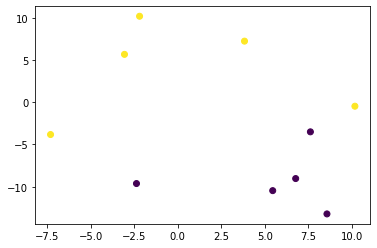

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.scatter(X[:, 0], X[:, 1], marker="o", c=y)

1.Start at the top node and at each node select the best split based on the largest information gain.

In [8]:
n_samples, n_features = X.shape
n_labels = len(np.unique(y))
feat_idxs = np.random.choice(n_features, n_features, replace=False)
print(feat_idxs)
X_column = X[:, 1]
print(X_column)
X_column = X[:, 0]
print(X_column)

[1 0]
[-13.22139309   7.2240226   -0.47693702   5.65851889  -9.62729945
  10.16886174  -9.03679096 -10.46669208  -3.50962228  -3.82795244]
[ 8.56415953  3.82754686 10.16987656 -3.06687647 -2.37785861 -2.20061694
  6.76724637  5.44808459  7.61319512 -7.31456312]


In [9]:
parent_entropy = entropy(y)
print(parent_entropy)
for feat_idx in feat_idxs:
    X_column = X[:, feat_idx]
    thresholds = np.unique(X_column)
    print(thresholds)
    for split_thresh in thresholds:
        print(np.argwhere(X_column <= split_thresh))
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        print('left_idxs=',left_idxs)
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        print('right_idxs=',right_idxs)
        
        # compute the weighted avg. of the loss for the children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        # information gain is difference in loss before vs. after split
        ig = parent_entropy - child_entropy
        print('ig=',ig)

1.0
[-13.22139309 -10.46669208  -9.62729945  -9.03679096  -3.82795244
  -3.50962228  -0.47693702   5.65851889   7.2240226   10.16886174]
[[0]]
left_idxs= [0]
right_idxs= [1 2 3 4 5 6 7 8 9]
ig= 0.10803154614559995
[[0]
 [7]]
left_idxs= [0 7]
right_idxs= [1 2 3 4 5 6 8 9]
ig= 0.2364527976600279
[[0]
 [4]
 [7]]
left_idxs= [0 4 7]
right_idxs= [1 2 3 5 6 8 9]
ig= 0.3958156020033583
[[0]
 [4]
 [6]
 [7]]
left_idxs= [0 4 6 7]
right_idxs= [1 2 3 5 8 9]
ig= 0.6099865470109875
[[0]
 [4]
 [6]
 [7]
 [9]]
left_idxs= [0 4 6 7 9]
right_idxs= [1 2 3 5 8]
ig= 0.2780719051126377
[[0]
 [4]
 [6]
 [7]
 [8]
 [9]]
left_idxs= [0 4 6 7 8 9]
right_idxs= [1 2 3 5]
ig= 0.6099865470109875
[[0]
 [2]
 [4]
 [6]
 [7]
 [8]
 [9]]
left_idxs= [0 2 4 6 7 8 9]
right_idxs= [1 3 5]
ig= 0.3958156020033583
[[0]
 [2]
 [3]
 [4]
 [6]
 [7]
 [8]
 [9]]
left_idxs= [0 2 3 4 6 7 8 9]
right_idxs= [1 5]
ig= 0.2364527976600279
[[0]
 [1]
 [2]
 [3]
 [4]
 [6]
 [7]
 [8]
 [9]]
left_idxs= [0 1 2 3 4 6 7 8 9]
right_idxs= [5]
ig= 0.108031546145599

In [10]:
def _split(X_column, split_thresh):
    left_idxs = np.argwhere(X_column <= split_thresh).flatten()
    right_idxs = np.argwhere(X_column > split_thresh).flatten()
    return left_idxs, right_idxs

def _information_gain(y, X_column, split_thresh):
     # parent loss
    parent_entropy = entropy(y)
     # generate split
    left_idxs, right_idxs = _split(X_column, split_thresh)
    if len(left_idxs) == 0 or len(right_idxs) == 0:
        return 0

    # compute the weighted avg. of the loss for the children
    n = len(y)
    n_l, n_r = len(left_idxs), len(right_idxs)
    e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
    child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

    # information gain is difference in loss before vs. after split
    ig = parent_entropy - child_entropy
    return ig

In [11]:
best_gain = -1
split_idx, split_thresh = None, None
for feat_idx in feat_idxs:
    X_column = X[:, feat_idx]
    thresholds = np.unique(X_column)
    for threshold in thresholds:
        gain = _information_gain(y, X_column, threshold)
        if gain > best_gain:
            best_gain = gain
            split_idx = feat_idx
            split_thresh = threshold
            print('split_idx=',split_idx,',split_thresh=',split_thresh, ',gain=',gain)
print('best_gain=',best_gain,' best_thresh=',split_thresh)

split_idx= 1 ,split_thresh= -13.221393094442398 ,gain= 0.10803154614559995
split_idx= 1 ,split_thresh= -10.466692076306323 ,gain= 0.2364527976600279
split_idx= 1 ,split_thresh= -9.627299454951007 ,gain= 0.3958156020033583
split_idx= 1 ,split_thresh= -9.036790957951375 ,gain= 0.6099865470109875
best_gain= 0.6099865470109875  best_thresh= -9.036790957951375
